# TinyCLIP Batch Image Scoring (Jupyter Notebook)

Run TinyCLIP on a folder of images matched by a glob pattern, compare against your list of text prompts, and display each image inline with its scores.

**Model:** `wkcn/TinyCLIP-ViT-61M-32-Text-29M-LAION400M` (works via 🤗 Transformers CLIPModel/CLIPProcessor)

If you want a smaller/faster TinyCLIP variant, you can switch the `MODEL_ID` below to another TinyCLIP from the model zoo.


In [2]:
# --- Install (uncomment if needed) ---
# If you're running this the first time, uncomment the next cell lines to install deps.
# %pip install --upgrade transformers pillow torch torchvision matplotlib huggingface_hub
# If you're on Apple Silicon and want MPS acceleration, make sure your PyTorch supports MPS.
!!pip install --upgrade transformers torch torchvision pillow matplotlib huggingface_hub


['Collecting transformers',
 '  Downloading transformers-4.55.2-py3-none-any.whl.metadata (41 kB)',
 'Requirement already satisfied: torch in /Users/ogw/miniconda3/envs/fox/lib/python3.13/site-packages (2.8.0)',
 'Requirement already satisfied: torchvision in /Users/ogw/miniconda3/envs/fox/lib/python3.13/site-packages (0.23.0)',
 'Requirement already satisfied: pillow in /Users/ogw/miniconda3/envs/fox/lib/python3.13/site-packages (11.3.0)',
 'Requirement already satisfied: matplotlib in /Users/ogw/miniconda3/envs/fox/lib/python3.13/site-packages (3.10.5)',
 'Requirement already satisfied: huggingface_hub in /Users/ogw/miniconda3/envs/fox/lib/python3.13/site-packages (0.34.4)',
 'Requirement already satisfied: filelock in /Users/ogw/miniconda3/envs/fox/lib/python3.13/site-packages (from transformers) (3.19.1)',
 'Requirement already satisfied: numpy>=1.17 in /Users/ogw/miniconda3/envs/fox/lib/python3.13/site-packages (from transformers) (2.2.6)',
 'Requirement already satisfied: packagi

In [12]:
from pathlib import Path
from glob import glob
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPModel, CLIPProcessor

# --- Configuration ---
MODEL_ID = "wkcn/TinyCLIP-ViT-61M-32-Text-29M-LAION400M"  # TinyCLIP model

# Device selection
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print("Using device:", DEVICE)


Using device: mps


In [13]:
# --- Load model and processor ---
dtype = torch.float16 if DEVICE.type in ("cuda", "mps") else torch.float32
model = CLIPModel.from_pretrained(MODEL_ID)
processor = CLIPProcessor.from_pretrained(MODEL_ID)
model = model.to(DEVICE)
if DEVICE.type == "cuda":
    model = model.to(dtype=dtype)
model.eval()
print("Model loaded:", MODEL_ID)


Model loaded: wkcn/TinyCLIP-ViT-61M-32-Text-29M-LAION400M


In [14]:
def score_image_against_prompts(image_path, prompts):
    # image = Image.open(image_path).convert('RGB')
    image = Image.open(image_path).convert('L').convert('RGB')
    inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)
    # Move tensors to device
    for k in inputs:
        inputs[k] = inputs[k].to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image  # shape: [1, len(prompts)]
        probs = logits_per_image.softmax(dim=1).squeeze(0).detach().cpu().numpy()
    return image, probs

def display_image_and_scores(image, prompts, probs, title=None):
    plt.figure()
    if title:
        plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    df = pd.DataFrame({"prompt": prompts, "probability": probs})
    df = df.sort_values("probability", ascending=False).reset_index(drop=True)
    display(df)
    return df


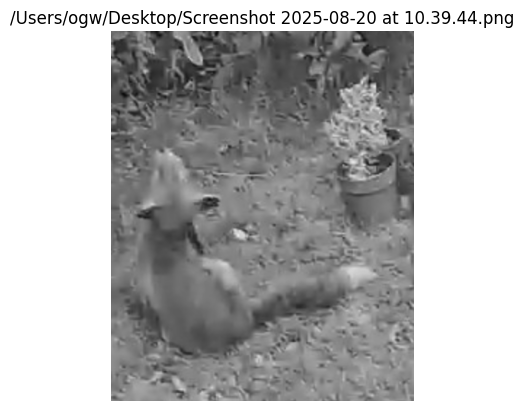

,prompt,probability
0,a fox,0.629396
1,a bird,0.240282
2,"blurry, pixelated photo of nothing",0.066589
3,a person,0.055331
4,a car,0.006765
5,a house,0.001637


prompt,a bird,a car,a fox,a house,a person,"blurry, pixelated photo of nothing"
image,,,,,,
/Users/ogw/Desktop/Screenshot 2025-08-20 at 10.39.44.png,0.240282,0.006765,0.629396,0.001637,0.055331,0.066589


In [22]:
IMAGE_GLOB = "motion_events/*/*.jpg"  # <- change me, e.g. './images/*.*' or '/path/**/*.png'
IMAGE_GLOB = "/Users/ogw/Desktop/Screenshot 2025-08-20 at 10.39.44.png"

PROMPTS = [
    "a fox",
    "a person",
    "a car",
    "a house",
    "blurry, pixelated photo of nothing",
    "a bird"
]  # <- edit this list to whatever concepts you want


# --- Run over image glob ---
paths = sorted(glob(IMAGE_GLOB, recursive=True))
assert len(paths) > 0, f"No images found for glob: {IMAGE_GLOB}"

all_rows = []
for p in paths:
    img, probs = score_image_against_prompts(p, PROMPTS)
    df = display_image_and_scores(img, PROMPTS, probs, title=str(p))
    for i, pr in enumerate(probs):
        all_rows.append({"image": p, "prompt": PROMPTS[i], "probability": float(pr)})

results = pd.DataFrame(all_rows)
results_wide = results.pivot(index="image", columns="prompt", values="probability").fillna(0.0)
display(results_wide)

# # Save CSVs
# ts = time.strftime("%Y%m%d-%H%M%S")
# out_long = f"tinyclip_results_long_{ts}.csv"
# out_wide = f"tinyclip_results_wide_{ts}.csv"
# results.to_csv(out_long, index=False)
# results_wide.to_csv(out_wide)
# print("Saved:", out_long, out_wide)


## Tips
- Modify `IMAGE_GLOB` to point at your images, e.g. `'/data/photos/**/*.png'`.
- Edit `PROMPTS` to whatever concepts you want to score.
- To speed up runs, keep the prompt list short.
- For even lower memory/compute, try a smaller TinyCLIP variant from the model zoo.
- If you **only** need image embeddings, you can compute `model.get_image_features(...)` once per image and do cosine similarity against precomputed text embeddings.
